In [4]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2
from preprocess import preprocessing
#from read_mias import *
import config
from object_detector import ObjectDetector
from custom_tensor_dataset import CustomTensorDataset
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.nn import CrossEntropyLoss
from torch.nn import MSELoss
from torch.optim import Adam
from torchvision.models import resnet50
from sklearn.model_selection import train_test_split
from imutils import paths
import pickle
import torch

import torchvision
from torchvision import transforms, datasets, models
import torch
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

Implementation References:

https://pyimagesearch.com/2021/11/01/training-an-object-detector-from-scratch-in-pytorch/

https://medium.com/@sharathhebbar24/object-detection-from-scratch-5ec93520adda

https://www.kaggle.com/code/daniel601/pytorch-fasterrcnn

https://discuss.pytorch.org/t/fasterrcnn-images-with-no-objects-present-cause-an-error/117974/3


# Preparation

In [5]:
dir = os.getcwd()
info = pd.read_csv(dir +'/mias_info/labels.txt', sep = ' ', header = None)
info.columns = ['refno', 'tissue', 'class', 'severity','x','y','r']
info['severity'] = info['severity'].fillna('N')
info['image_id'] = info.refno.str.split('b', expand = True)[1].astype(int) -1
info.head()


,refno,tissue,class,severity,x,y,r,image_id
0,mdb001,G,CIRC,B,535,425,197.0,0
1,mdb002,G,CIRC,B,522,280,69.0,1
2,mdb003,D,NORM,N,NaN,NaN,NaN,2
3,mdb004,D,NORM,N,NaN,NaN,NaN,3
4,mdb005,F,CIRC,B,477,133,30.0,4


In [6]:
data_transform = transforms.Compose([
        transforms.ToTensor(), 
    ])

dataset = CustomTensorDataset(data_transform)


def collate_fn(batch):
    return tuple(zip(*batch))

data_loader = torch.utils.data.DataLoader(dataset, 
                                          batch_size=config.BATCH_SIZE, 
                                          collate_fn=collate_fn)

In [7]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)
for imgs, annotations in data_loader:
    imgs = list(img.to(device) for img in imgs)
    annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
    print(annotations)
    break



cpu
[{'boxes': tensor([[0.3301, 0.3926, 0.7148, 0.7773]]), 'labels': tensor([1]), 'image_id': tensor([0])}, {'boxes': tensor([[0.4424, 0.6592, 0.5771, 0.7939]]), 'labels': tensor([1]), 'image_id': tensor([1])}, {'boxes': tensor([], size=(0, 4)), 'labels': tensor([0]), 'image_id': tensor([2])}, {'boxes': tensor([], size=(0, 4)), 'labels': tensor([0]), 'image_id': tensor([3])}, {'boxes': tensor([[0.4365, 0.8408, 0.4951, 0.8994],
        [0.4629, 0.8105, 0.5137, 0.8613]]), 'labels': tensor([1, 1]), 'image_id': tensor([4])}, {'boxes': tensor([], size=(0, 4)), 'labels': tensor([0]), 'image_id': tensor([5])}, {'boxes': tensor([], size=(0, 4)), 'labels': tensor([0]), 'image_id': tensor([6])}, {'boxes': tensor([], size=(0, 4)), 'labels': tensor([0]), 'image_id': tensor([7])}, {'boxes': tensor([], size=(0, 4)), 'labels': tensor([0]), 'image_id': tensor([8])}, {'boxes': tensor([[0.4805, 0.5527, 0.5449, 0.6172]]), 'labels': tensor([1]), 'image_id': tensor([9])}, {'boxes': tensor([], size=(0, 4)),

# Model Selection

Currently using an RCNN like the third reference

In [8]:
def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [9]:
# 3 features because using classifying into 3 severities: 
# normal, benign, malignant

model = get_model_instance_segmentation(3)



c:\Users\niroo\bioe486_project\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\niroo\bioe486_project\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
0.9%

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to C:\Users\niroo/.cache\torch\hub\checkpoints\fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


100.0%


# Training

`config` file currently set for

20 epochs

batch size 32

change as necessary in the `config` before running

In [10]:
num_epochs = config.NUM_EPOCHS
model.to(device)
    
# parameters
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)

len_dataloader = len(data_loader)

for epoch in range(num_epochs):
    model.train()
    i = 0    
    epoch_loss = 0
    for imgs, annotations in data_loader:
        i += 1
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        loss_dict = model([imgs[0]], [annotations[0]])
        losses = sum(loss for loss in loss_dict.values())        

        optimizer.zero_grad()
        losses.backward()
        optimizer.step() 
#         print(f'Iteration: {i}/{len_dataloader}, Loss: {losses}')
        epoch_loss += losses
    print(epoch_loss)

tensor(7.1973, grad_fn=<AddBackward0>)
tensor(2.4070, grad_fn=<AddBackward0>)
tensor(1.8437, grad_fn=<AddBackward0>)
tensor(1.8002, grad_fn=<AddBackward0>)
tensor(1.7629, grad_fn=<AddBackward0>)
tensor(1.2967, grad_fn=<AddBackward0>)
tensor(1.3186, grad_fn=<AddBackward0>)
tensor(1.1131, grad_fn=<AddBackward0>)
tensor(1.5210, grad_fn=<AddBackward0>)
tensor(0.8106, grad_fn=<AddBackward0>)
tensor(0.8776, grad_fn=<AddBackward0>)
tensor(1.2451, grad_fn=<AddBackward0>)
tensor(0.8266, grad_fn=<AddBackward0>)
tensor(1.0552, grad_fn=<AddBackward0>)
tensor(1.7294, grad_fn=<AddBackward0>)
tensor(0.9123, grad_fn=<AddBackward0>)
tensor(1.0682, grad_fn=<AddBackward0>)
tensor(0.8787, grad_fn=<AddBackward0>)
tensor(0.6755, grad_fn=<AddBackward0>)
tensor(0.7977, grad_fn=<AddBackward0>)


Epoch 1/20, Loss: 0.855404349451419
Epoch 2/20, Loss: 1.043636788148433
Epoch 3/20, Loss: 0.8873620577596739
Epoch 4/20, Loss: 0.7860761575866491
Epoch 5/20, Loss: 1.0887911771278596
Epoch 6/20, Loss: 1.0854907063330757
Epoch 7/20, Loss: 0.6675766177941114
Epoch 8/20, Loss: 0.8933018746611197
Epoch 9/20, Loss: 0.8222173585963901
Epoch 10/20, Loss: 0.6786381450365297
Epoch 11/20, Loss: 0.9473221397201996
Epoch 12/20, Loss: 1.0070373082708102
Epoch 13/20, Loss: 0.7303140652074944
Epoch 14/20, Loss: 0.9177433695585933
Epoch 15/20, Loss: 0.8188434623079957
Epoch 16/20, Loss: 0.898346702922936
Epoch 17/20, Loss: 0.8267613556672586
Epoch 18/20, Loss: 0.9678640892379917
Epoch 19/20, Loss: 0.6944061931717442
Epoch 20/20, Loss: 0.6761044365848647


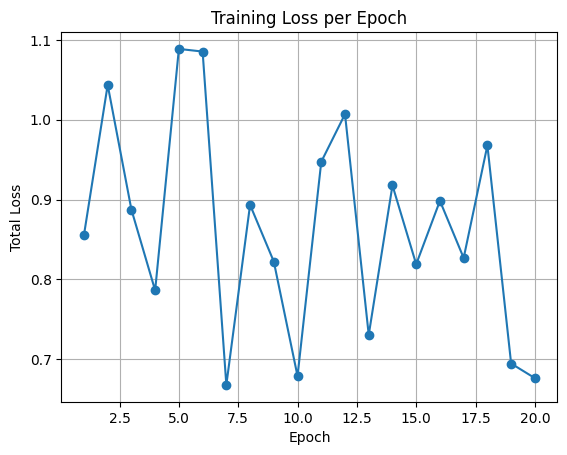

In [11]:
import matplotlib.pyplot as plt

epoch_losses = []  # Store epoch losses

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    
    for imgs, annotations in data_loader:
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        loss_dict = model([imgs[0]], [annotations[0]])
        losses = sum(loss for loss in loss_dict.values())        

        optimizer.zero_grad()
        losses.backward()
        optimizer.step() 

        epoch_loss += losses.item()  # Make sure to use .item() to extract scalar from tensor
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss}")
    epoch_losses.append(epoch_loss)

# Plotting
plt.figure()
plt.plot(range(1, num_epochs+1), epoch_losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Total Loss')
plt.title('Training Loss per Epoch')
plt.grid(True)
plt.show()


# Predictions

In [12]:
for imgs, annotations in data_loader:
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        break


In [13]:
model.eval()
preds = model(imgs)
preds

[{'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>),
  'labels': tensor([], dtype=torch.int64),
  'scores': tensor([], grad_fn=<IndexBackward0>)},
 {'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>),
  'labels': tensor([], dtype=torch.int64),
  'scores': tensor([], grad_fn=<IndexBackward0>)},
 {'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>),
  'labels': tensor([], dtype=torch.int64),
  'scores': tensor([], grad_fn=<IndexBackward0>)},
 {'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>),
  'labels': tensor([], dtype=torch.int64),
  'scores': tensor([], grad_fn=<IndexBackward0>)},
 {'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>),
  'labels': tensor([], dtype=torch.int64),
  'scores': tensor([], grad_fn=<IndexBackward0>)},
 {'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>),
  'labels': tensor([], dtype=torch.int64),
  'scores': tensor([], grad_fn=<IndexBackward0>)},
 {'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>),
  

Prediction


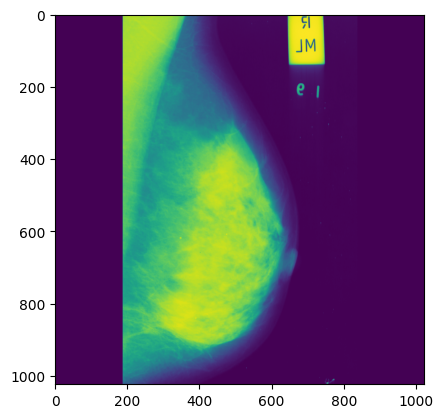

Target


In [14]:
from plotting import plot_image
idx = 3
print("Prediction")
plot_image(imgs[idx], preds[idx])
print("Target")


{'boxes': tensor([], size=(0, 4)), 'labels': tensor([0]), 'image_id': tensor([3])}


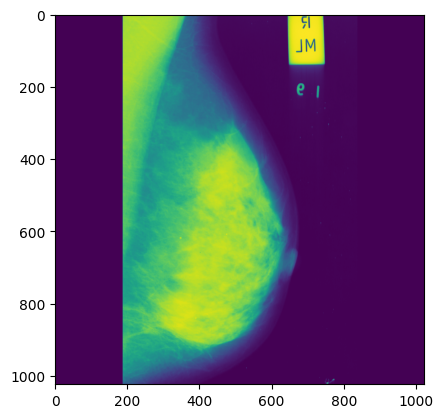

In [15]:
img = imgs[idx]
annot = annotations[idx]
print(annot)
plot_image(imgs[idx], annotations[idx])